# Contextual Preference Ranking and Reinforcement Learning for Gin Rummy
### Mykola Zaitsev, k12147393

### Libraries
- We use ***gin_rummy_v4*** environment from *pettingzoo* (more details: https://pettingzoo.farama.org/environments/classic/gin_rummy/)
- *numpy* for operations, *matplotlib* for plotting
- *PyTorch* for Siamese neural network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import random

from pettingzoo.classic import gin_rummy_v4

### Siamese Neural Network for Contextual Preference Ranking

First layer has 52 input size for 52 cards in deck

In [2]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(52, 64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward_one(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

    def forward(self, hand, card):
        hand_embedded = self.forward_one(hand)
        card_embedded = self.forward_one(card)
        distance = torch.abs(hand_embedded - card_embedded)
        similarity_score = torch.sigmoid(-torch.norm(distance, dim=1))
        return similarity_score

## Q-Learning with Neural Network

Epsilon-greedy action selection with Siamese network to evaluate card fit

In [3]:
class RLAgentWithRanking:
    def __init__(self, action_space, observation_space, siamese_model, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.epsilon = epsilon  
        self.alpha = alpha  
        self.gamma = gamma 
        self.action_space = action_space
        self.q_table = {}  
        self.siamese_model = siamese_model
        self.optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def get_state(self, observation):
        state = tuple(observation.flatten())
        return state

    def choose_action(self, state, action_mask):
        if np.random.rand() < self.epsilon:
            legal_actions = np.where(action_mask == 1)[0]
            return np.random.choice(legal_actions)
        else:
            q_values = [self.q_table.get((state, a), 0) for a in range(len(action_mask))]
            legal_q_values = [(q, a) for a, q in enumerate(q_values) if action_mask[a] == 1]
            if legal_q_values:
                return max(legal_q_values, key=lambda x: x[0])[1]
            else:
                return random.choice(np.where(action_mask == 1)[0])

    def update_q_table(self, state, action, reward, next_state, done, action_mask):
        current_q = self.q_table.get((state, action), 0)
        if sum(action_mask) == 0:
            max_next_q = 0  
        if done:
            max_next_q = 0  
        else:
            q_values_next = [self.q_table.get((next_state, a), 0) for a in range(len(action_mask))]
            max_next_q = max([q for a, q in enumerate(q_values_next) if action_mask[a] == 1], default=0)

        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[(state, action)] = new_q

    def train_siamese(self, current_hand, new_card, target):
        self.siamese_model.train()
        current_hand_tensor = torch.tensor(current_hand, dtype=torch.float32).unsqueeze(0)
        new_card_tensor = torch.tensor(new_card, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

        similarity_score = self.siamese_model(current_hand_tensor, new_card_tensor)
        loss = self.criterion(similarity_score, target_tensor)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Compute a reward for adding a new card based on deadwood reduction.

In [4]:
def calculate_deadwood(hand):
    deadwood = 0
    for i, val in enumerate(hand):
        if val == 1: 
            rank = (i % 13) + 1
            deadwood += rank if rank <= 10 else 10 
    return deadwood


def calculate_reward_target(current_hand, new_card):
    hand_with_card = np.clip(current_hand + new_card, 0, 1)
    original_deadwood = calculate_deadwood(current_hand)
    new_deadwood = calculate_deadwood(hand_with_card)
    reward = max(0, original_deadwood - new_deadwood)
    return reward / original_deadwood if original_deadwood > 0 else 1.0

## Training
- Player 0 uses Q-Learning with Siamese Neural Network to evaluate card usefulness
- Player 1 has random policy

In [5]:
player_0_rewards = []
player_1_rewards = []

env = gin_rummy_v4.env(knock_reward=0.5, gin_reward=1.0)
env.reset()  

siamese_model = SNN()
player_0 = RLAgentWithRanking(env.action_space('player_0'), env.observation_space('player_0'), siamese_model)
agents = [RLAgentWithRanking(env.action_space(agent), env.observation_space(agent), siamese_model) for agent in env.agents]

num_episodes = 1000

for episode in range(num_episodes):
    env.reset()
    done = {agent: False for agent in env.agents}
    total_rewards = {agent: 0 for agent in env.agents}

    while not all(done.values()):
        for agent in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()

            if termination or truncation:
                action = None
                done[agent] = True
            elif agent == 'player_0':
                current_hand = observation["observation"][0]
                new_card = observation["observation"][1]
                target = calculate_reward_target(current_hand, new_card)
                player_0.train_siamese(current_hand, new_card, target)

                state = player_0.get_state(observation["observation"])
                action = player_0.choose_action(state, observation["action_mask"])

                player_0.update_q_table(
                    state=state,
                    action=action,
                    reward=reward,
                    next_state=player_0.get_state(observation['observation']),
                    done=termination,
                    action_mask=observation["action_mask"]
                )
            else:
                mask = observation["action_mask"]
                action = env.action_space(agent).sample(mask)

            env.step(action)
            total_rewards[agent] += reward

    if (episode+1)%100==0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Rewards = {total_rewards}")
        
    player_0_rewards.append(total_rewards['player_0'])
    player_1_rewards.append(total_rewards['player_1'])

env.close()

Episode 100/1000: Total Rewards = {'player_0': -0.29, 'player_1': -0.73}
Episode 200/1000: Total Rewards = {'player_0': -0.2, 'player_1': -0.32}
Episode 300/1000: Total Rewards = {'player_0': -0.52, 'player_1': -0.41}
Episode 400/1000: Total Rewards = {'player_0': -0.27, 'player_1': -0.44}
Episode 500/1000: Total Rewards = {'player_0': -0.41, 'player_1': -0.55}
Episode 600/1000: Total Rewards = {'player_0': -0.36, 'player_1': -0.81}
Episode 700/1000: Total Rewards = {'player_0': -0.42, 'player_1': -0.61}
Episode 800/1000: Total Rewards = {'player_0': -0.73, 'player_1': -0.46}
Episode 900/1000: Total Rewards = {'player_0': -0.79, 'player_1': -0.24}
Episode 1000/1000: Total Rewards = {'player_0': -0.36, 'player_1': -0.66}


### Results
- Number of times Player 0 went Gin (best outcome)
- Win percentage

In [6]:
print("Player 0 went Gin",player_0_rewards.count(1), "times")

result = [a - b for a, b in zip(player_0_rewards, player_1_rewards)]
print("Win percentage:", (sum(1 for x in result if x > 0))/num_episodes * 100, "%")

Player 0 went Gin 43 times
Win percentage: 70.0 %


### Rewards plot

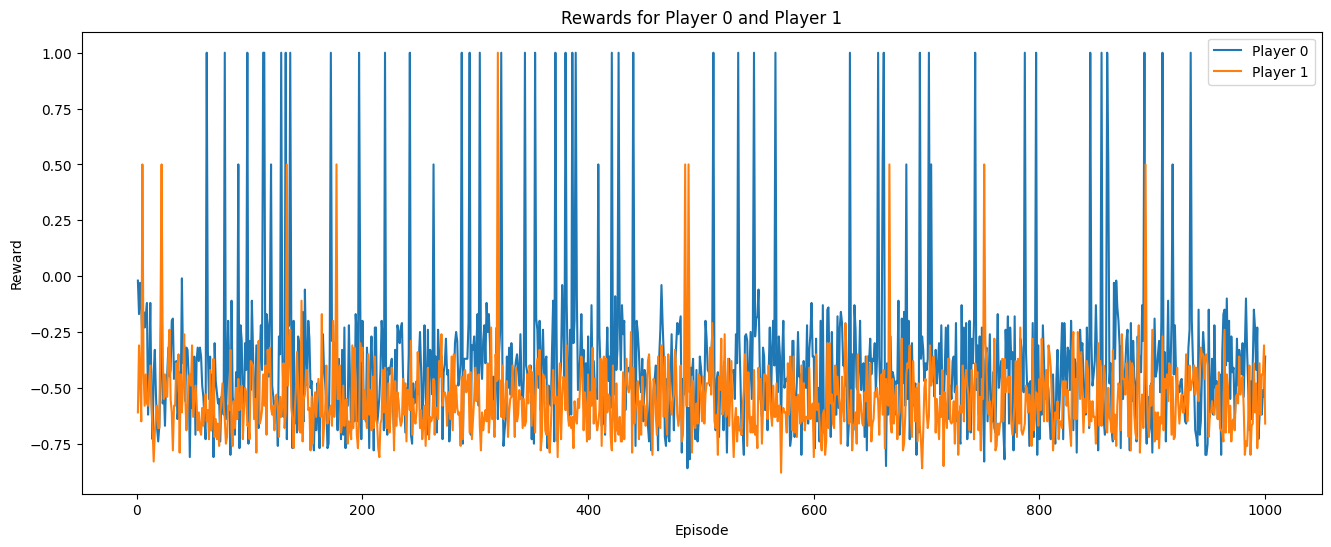

In [7]:
plt.figure(figsize=(16, 6))
plt.plot(range(1, num_episodes + 1), player_0_rewards, label='Player 0')
plt.plot(range(1, num_episodes + 1), player_1_rewards, label='Player 1')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards for Player 0 and Player 1')
plt.legend()
plt.show()

### Update choosing process

- Counting sets  and runs
- Comparing meld count before and after adding a new card
- Encourage to form melds over reducing deadwood

In [8]:
def calculate_meld_potential(current_hand, new_card):
    def parse_hand_vector(hand_vector):
        suits = ["spades", "hearts", "diamonds", "clubs"]
        hand = {suit: [] for suit in suits}
        for i, card in enumerate(hand_vector):
            if card == 1:
                suit = suits[i // 13]
                rank = i % 13 + 1
                hand[suit].append(rank)
        return hand

    def count_melds(hand):
        meld_count = 0
        ranks = [0] * 13
        for suit, ranks_in_suit in hand.items():
            for rank in ranks_in_suit:
                ranks[rank - 1] += 1
        meld_count += sum(1 for rank_count in ranks if rank_count >= 3)
        for suit, ranks_in_suit in hand.items():
            sorted_ranks = sorted(ranks_in_suit)
            run_length = 1
            for i in range(1, len(sorted_ranks)):
                if sorted_ranks[i] == sorted_ranks[i - 1] + 1:
                    run_length += 1
                else:
                    run_length = 1
                if run_length >= 3:
                    meld_count += 1
                    break
        return meld_count

    current_hand_parsed = parse_hand_vector(current_hand)
    new_card_parsed = parse_hand_vector(new_card)

    for suit, ranks_in_suit in new_card_parsed.items():
        current_hand_parsed[suit].extend(ranks_in_suit)

    melds_before = count_melds(parse_hand_vector(current_hand))
    melds_after = count_melds(current_hand_parsed)
    return melds_after - melds_before

def calculate_reward_target(current_hand, new_card):
    meld_potential = calculate_meld_potential(current_hand, new_card)
    deadwood_reduction = calculate_deadwood(current_hand) - calculate_deadwood(current_hand + new_card)
    return meld_potential + max(0, deadwood_reduction / 10)

In [9]:
player_0_rewards = []
player_1_rewards = []

env = gin_rummy_v4.env(knock_reward=0.5, gin_reward=1.0)
env.reset()

siamese_model = SNN()
player_0 = RLAgentWithRanking(env.action_space('player_0'), env.observation_space('player_0'), siamese_model)
agents = [RLAgentWithRanking(env.action_space(agent), env.observation_space(agent), siamese_model) for agent in env.agents]

num_episodes = 1000

for episode in range(num_episodes):
    env.reset()
    done = {agent: False for agent in env.agents}
    total_rewards = {agent: 0 for agent in env.agents}

    while not all(done.values()):
        for agent in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()

            if termination or truncation:
                action = None
                done[agent] = True
            elif agent == 'player_0':
                current_hand = observation["observation"][0]
                new_card = observation["observation"][1]

                meld_potential = calculate_meld_potential(current_hand, new_card)
                player_0.train_siamese(current_hand, new_card, meld_potential)

                state = player_0.get_state(observation["observation"])
                action = player_0.choose_action(state, observation["action_mask"])

                player_0.update_q_table(
                    state=state,
                    action=action,
                    reward=reward,
                    next_state=player_0.get_state(observation['observation']),
                    done=termination,
                    action_mask=observation["action_mask"]
                )
            else:
                mask = observation["action_mask"]
                action = env.action_space(agent).sample(mask)

            env.step(action)
            total_rewards[agent] += reward

    if (episode+1)%100==0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Rewards = {total_rewards}")
        
    player_0_rewards.append(total_rewards['player_0'])
    player_1_rewards.append(total_rewards['player_1'])

env.close()

Episode 100/1000: Total Rewards = {'player_0': -0.42, 'player_1': -0.43}
Episode 200/1000: Total Rewards = {'player_0': -0.44, 'player_1': -0.65}
Episode 300/1000: Total Rewards = {'player_0': -0.31, 'player_1': -0.38}
Episode 400/1000: Total Rewards = {'player_0': -0.35, 'player_1': -0.29}
Episode 500/1000: Total Rewards = {'player_0': -0.71, 'player_1': -0.68}
Episode 600/1000: Total Rewards = {'player_0': -0.51, 'player_1': -0.26}
Episode 700/1000: Total Rewards = {'player_0': -0.49, 'player_1': 0.5}
Episode 800/1000: Total Rewards = {'player_0': -0.3, 'player_1': -0.56}
Episode 900/1000: Total Rewards = {'player_0': -0.27, 'player_1': -0.72}
Episode 1000/1000: Total Rewards = {'player_0': 1.0, 'player_1': -0.69}


### Results
- Number of times Player 0 went Gin (best outcome)
- Win percentage

In [10]:
print("Player 0 went Gin",player_0_rewards.count(1), "times")

result = [a - b for a, b in zip(player_0_rewards, player_1_rewards)]
print("Win percentage:", (sum(1 for x in result if x > 0))/num_episodes * 100, "%")

Player 0 went Gin 51 times
Win percentage: 68.89999999999999 %


### Rewards plot

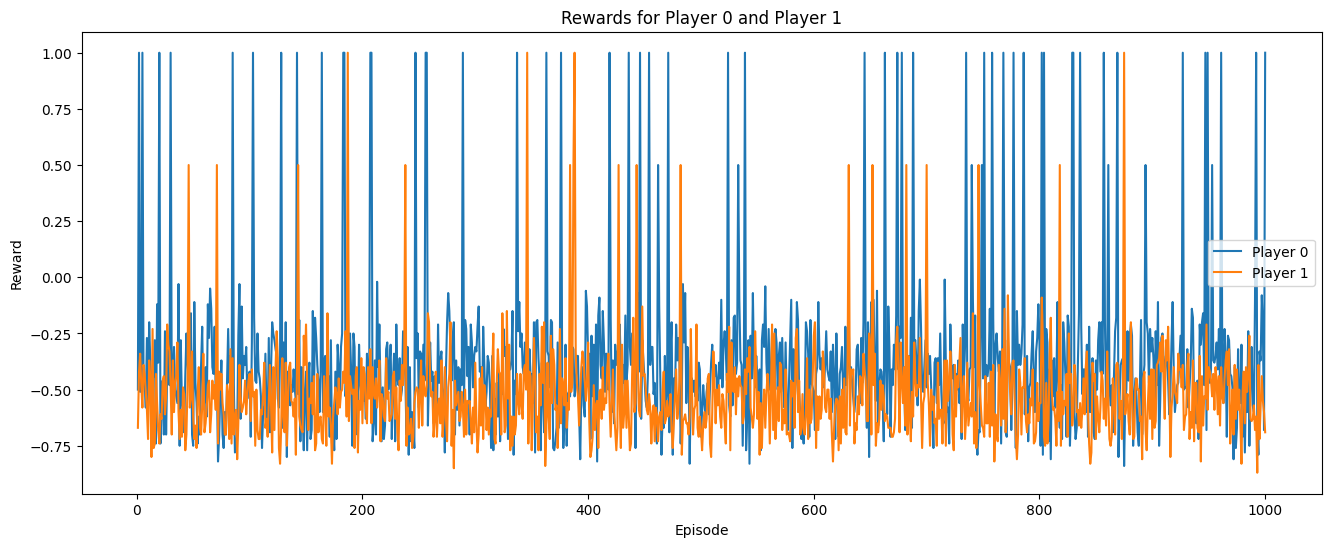

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(range(1, num_episodes + 1), player_0_rewards, label='Player 0')
plt.plot(range(1, num_episodes + 1), player_1_rewards, label='Player 1')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards for Player 0 and Player 1')
plt.legend()
plt.show()